In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/hindi-character-recognition.zip" "/content"

In [ ]:
!unzip *.zip && rm -rf *.zip

#Dataset Preprocessing

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode="nearest",
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    "/content/DevanagariHandwrittenCharacterDataset/Train",
    target_size=(48, 48),
    batch_size=128,
    color_mode="grayscale",
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    "/content/DevanagariHandwrittenCharacterDataset/Test",
    target_size=(48, 48),
    batch_size=128,
    color_mode="grayscale",
    class_mode="categorical"
)

Found 78200 images belonging to 46 classes.
Found 13800 images belonging to 46 classes.


In [17]:
classnames = list(train_generator.class_indices.keys())
numclasses = len(classnames)

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_generator(generator):
  plt.figure(figsize=[15,15])
  images, labels = next(generator)
  for i in range(5 * 5):
      plt.subplot(5,5,i+1)
      plt.imshow(images[i].reshape(48, 48))
      plt.title(classnames[np.argmax(labels[i])])
      plt.axis("off")
  plt.show()

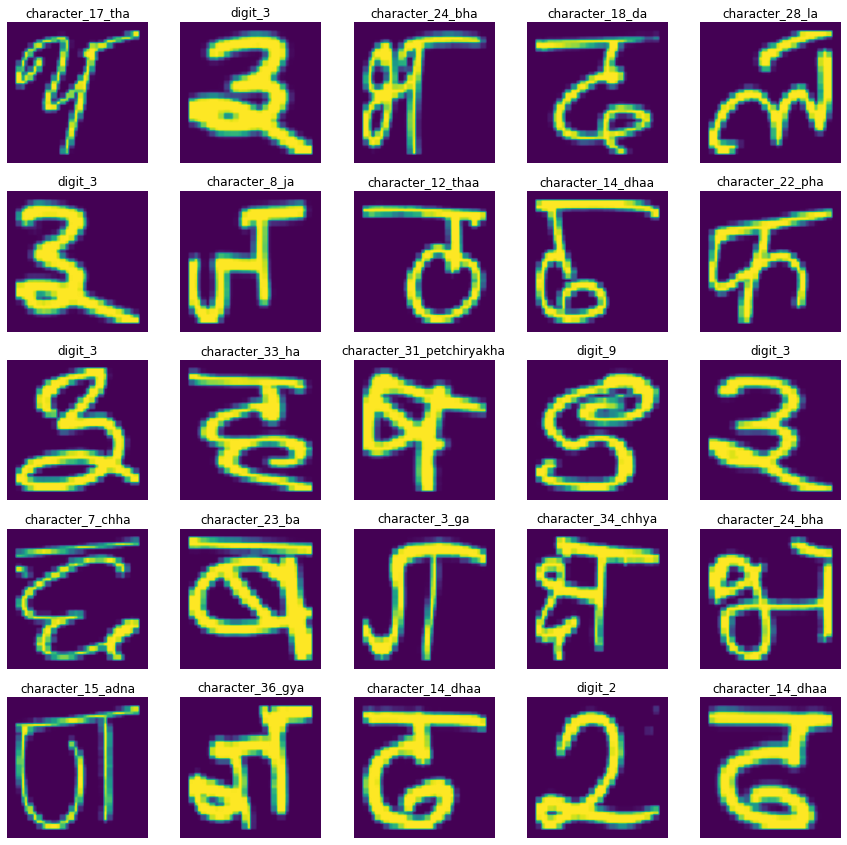

In [25]:
plot_generator(test_generator)

#Model

In [26]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [28]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(48, 48, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=numclasses, activation="softmax"))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

In [30]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "model.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)
callbacks = [earlystop, checkpoint]

In [32]:
history = model.fit(
  train_generator,
  epochs = 100,
  callbacks=callbacks,
  validation_data=test_generator
)

Epoch 1/100
611/611 [==============================] - ETA: 0s - loss: 3.0611 - accuracy: 0.1557
Epoch 1: val_loss improved from inf to 2.34386, saving model to model.h5
611/611 [==============================] - 94s 136ms/step - loss: 3.0611 - accuracy: 0.1557 - val_loss: 2.3439 - val_accuracy: 0.2993
Epoch 2/100
611/611 [==============================] - ETA: 0s - loss: 1.9456 - accuracy: 0.4128
Epoch 2: val_loss improved from 2.34386 to 1.51829, saving model to model.h5
611/611 [==============================] - 80s 132ms/step - loss: 1.9456 - accuracy: 0.4128 - val_loss: 1.5183 - val_accuracy: 0.5425
Epoch 3/100
611/611 [==============================] - ETA: 0s - loss: 1.4729 - accuracy: 0.5513
Epoch 3: val_loss improved from 1.51829 to 1.17506, saving model to model.h5
611/611 [==============================] - 80s 132ms/step - loss: 1.4729 - accuracy: 0.5513 - val_loss: 1.1751 - val_accuracy: 0.6312
Epoch 4/100
611/611 [==============================] - ETA: 0s - loss: 1.2272 - 

#Visualization

In [35]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_generator_predictions(generator):
  plt.figure(figsize=[15,15])
  images, labels = next(generator)
  for i in range(5 * 5):
      output = None
      plt.subplot(5,5,i+1)
      plt.imshow(images[i].reshape(48, 48))
      prediction = model.predict(tf.expand_dims(images[i], 0))
      output = classnames[np.argmax(prediction)]
      plt.title(f"Prediction: {output}")
      plt.axis('off')
  plt.show()

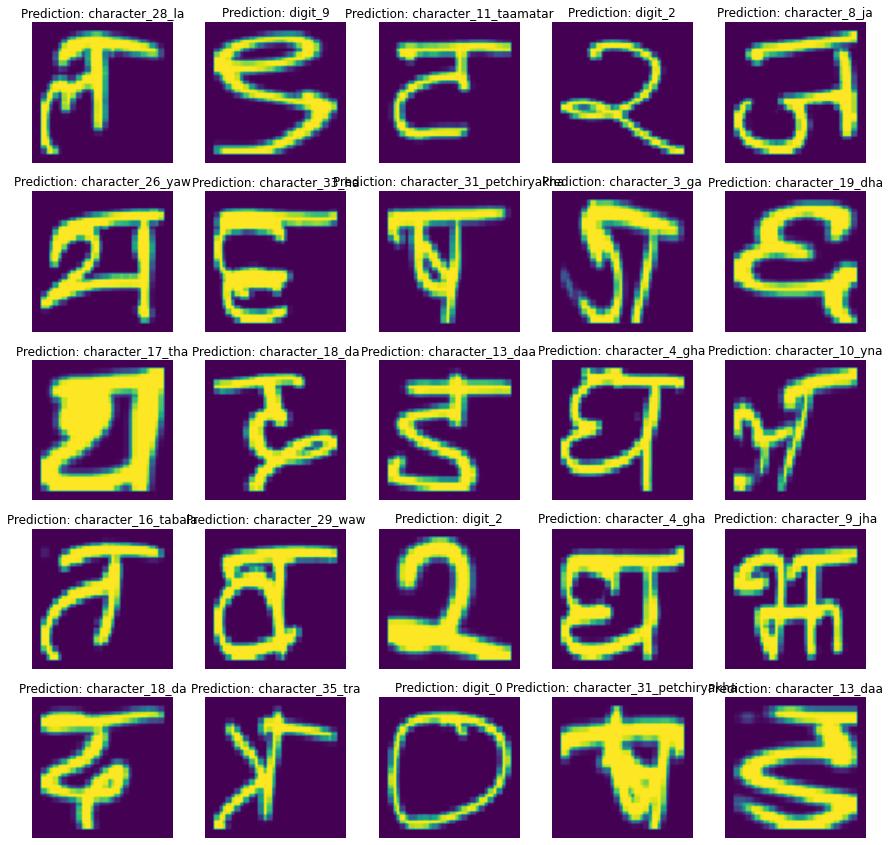

In [36]:
plot_generator_predictions(test_generator)

In [37]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

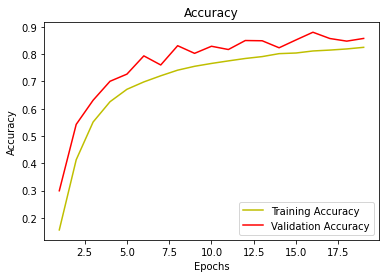

In [38]:
plt.plot(epochs, accuracy, "y", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

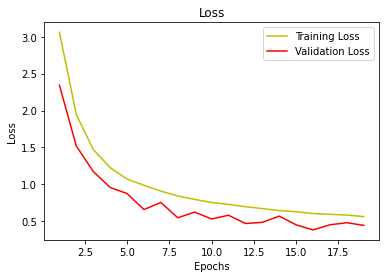

In [39]:
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Implemented By Muhammad Hanan Asghar